In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer


In [2]:
import os
import numpy as np

import warnings

import sklearn.linear_model
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

x_train_df = pd.read_csv('../data/data_reviews/x_train.csv')
y_train_df = pd.read_csv('../data/data_reviews/y_train.csv')
x_test_df = pd.read_csv('../data/data_reviews/x_test.csv')

In [3]:
x_train = x_train_df['text'] 
x_test = x_test_df['text']
x_train

0       Oh and I forgot to also mention the weird colo...
1                            THAT one didn't work either.
2                                      Waste of 13 bucks.
3       Product is useless, since it does not have eno...
4       None of the three sizes they sent with the hea...
                              ...                        
2395    The sweet potato fries were very good and seas...
2396    I could eat their bruschetta all day it is dev...
2397                                 Ambience is perfect.
2398    We ordered the duck rare and it was pink and t...
2399         Service was good and the company was better!
Name: text, Length: 2400, dtype: object

In [4]:
amazon_i = np.where(x_train_df['website_name']=='amazon')
imdb_i = np.where(x_train_df['website_name']=='imdb')
yelp_i =  np.where(x_train_df['website_name']=='yelp')

## Preprocess

In [5]:
import pandas as pd
import numpy as np
import sklearn.neighbors

from collections import OrderedDict

word_embeddings = pd.read_csv('../data/pretrained_word_embeddings/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

## Show some examples

n_words = len(word2vec.keys())
print("word2vec['happy'] = ")
print(word2vec['happy'])

## Try some analogies
def analogy_lookup(a1, a2, b1):
    target_vec = word2vec[a2] - word2vec[a1] + word2vec[b1]
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=7, metric='euclidean', algorithm='brute')
    knn.fit(word_embeddings.values)
    dists, indices = knn.kneighbors(target_vec[np.newaxis,:])
    print("Query: %s:%s -> %s:____" % (a1, a2, b1))
    for ii, vv in enumerate(indices[0]):
        print("   %20s  at dist %.3f" % (word_list[vv], dists[0,ii]))

analogy_lookup('movie', 'film', 'theater')

word2vec['happy'] = 
[ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]
Query: movie:film -> theater:____
                theatre  at dist 1.977
                theater  at dist 2.158
                 cinema  at dist 3.639
                  opera  at dist 3.654
                 ballet  at dist 3.729
               ensemble  at dist 3.817
                 studio  at dist 3.967


# process words

In [6]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [8]:
from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
porterstemmer = PorterStemmer()
wnl = WordNetLemmatizer()
spell = Speller()

common_words = pd.read_csv('../data/data_reviews/modified_stopword.txt')

In [9]:
print(common_words['words'])

0              i
1             me
2             my
3         myself
4             we
5            our
6           ours
7      ourselves
8            you
9           your
10         yours
11      yourself
12    yourselves
13            he
14           him
15           his
16       himself
17           she
18           her
19          hers
20       herself
21            it
22           its
23        itself
24          they
25          them
26         their
27        theirs
28    themselves
29          what
30         which
31           who
32          whom
33          this
34          that
35         these
36         those
37            am
38            is
39           are
40           was
41          were
42            be
43          been
44         being
45          have
46           has
47           had
48        having
49            do
50          does
51           did
52         doing
53             a
54            an
55           the
56           and
57            if
58            

In [15]:
# words_ = ['i', 'hey', 'you']

# if words_[2] not in test_stop_words:
#     print(words_[2])
# #     words_ = [w for w in words_ if w not in stop_words]
# # words_

In [16]:
import re

def simple_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()   
    return words

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stemming_tokenizer(str_input):
    words = decontracted(str_input)
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    
    # autocorrect
    test_names = words
    test_names_len = len(words)
    words = [spell(test_names[i]) for i in range(test_names_len)]

    # prune words
#     def prune_food(w):
#         if w == 'bones' or w == 'bone' or w == 'fish' or w == 'worms' or w == 'worm':
#             w = 'food'
#         return w
    
#     words = [prune_food(word) for word in words]
    
    # stemming 
#     porter_stemmer = PorterStemmer()
#     words = [porter_stemmer.stem(word) for word in words]
    
    #remove non important words
#     non_important = ['film', 'movie','apple', 'juice']
#     words = [w for w in words if w not in non_important]
    
#     stop_words = common_words['words']
#     stop_words = pd.Series(stop_words).array
#     words = [w for w in words if w not in stop_words]
    
    return words

In [17]:
words = [stemming_tokenizer(x_train[i]) for i in range(len(x_train))]

flat_list = sum(words, [])
len(flat_list)

flat_list

['oh',
 'and',
 'i',
 'forgot',
 'to',
 'also',
 'mention',
 'the',
 'weird',
 'color',
 'effect',
 'it',
 'has',
 'on',
 'your',
 'phone',
 'that',
 'one',
 'didn',
 't',
 'work',
 'either',
 'waste',
 'of',
 'bucks',
 'product',
 'is',
 'useless',
 'since',
 'it',
 'does',
 'not',
 'have',
 'enough',
 'charging',
 'current',
 'to',
 'charge',
 'the',
 'cellphone',
 'i',
 'was',
 'planning',
 'to',
 'use',
 'it',
 'with',
 'none',
 'of',
 'the',
 'three',
 'sizes',
 'they',
 'sent',
 'with',
 'the',
 'headset',
 'would',
 'stay',
 'in',
 'my',
 'ears',
 'worst',
 'customer',
 'service',
 'the',
 'engage',
 'is',
 'still',
 'lacking',
 'in',
 'earbuds',
 'it',
 'always',
 'cuts',
 'out',
 'and',
 'makes',
 'a',
 'been',
 'been',
 'been',
 'sound',
 'then',
 'says',
 'signal',
 'failed',
 'the',
 'only',
 'very',
 'disappointing',
 'thing',
 'was',
 'there',
 'was',
 'no',
 'speakerphone',
 'very',
 'disappointed',
 'in',
 'accessoryone',
 'basically',
 'the',
 'service',
 'was',
 'very

In [18]:
len(flat_list)

28937

In [19]:
words_te = [stemming_tokenizer(x_test[i]) for i in range(len(x_test))]

flat_list_te = sum(words_te, [])
len(flat_list_te)

7195

## Taking the Average

In [20]:
keys = word2vec.keys()

In [21]:
x_tr = []

for x in range(len(words)):
    filtered_init = []
    for i in range(len(words[x])):
        if (words[x][i] in keys):
            filtered_init.append(words[x][i])
            filtered = set(filtered_init)
        t = [word2vec[w].reshape(50) for w in filtered]
    x_tr.append(np.average(t, axis=0))

# x = np.array(x_tr)
x_tr

[array([ 2.27492394e-01,  2.71890437e-01,  2.33111250e-02, -5.44937500e-02,
         3.28966125e-01,  5.61015000e-02, -3.28511875e-01, -1.54802562e-01,
        -1.80857577e-01,  1.41382411e-01,  2.24468750e-03,  2.90243313e-01,
        -2.43689875e-01, -6.01350000e-02,  4.76835719e-01,  3.63811875e-01,
        -2.48924812e-01, -3.72113125e-02, -1.11023375e-01, -4.21776313e-01,
         2.85201250e-02,  1.91316500e-01,  4.34867750e-01,  6.84978750e-02,
         3.22932125e-01, -1.58827850e+00, -7.21532312e-01,  2.95250812e-01,
         4.60154750e-01, -5.33041250e-01,  2.96686250e+00,  2.29191525e-01,
        -2.80384937e-01, -2.51196875e-01, -2.24072544e-02, -8.90863812e-02,
         1.62166250e-01,  1.02623875e-01,  3.78294375e-02, -1.30695000e-01,
         6.39304812e-02,  2.10805125e-01, -1.94016687e-01,  1.23212250e-01,
        -5.13953125e-02,  1.19507938e-01, -9.21896250e-03, -9.51979375e-02,
         6.76542500e-03,  1.43441437e-01]),
 array([ 0.281963  ,  0.13245333,  0.3476833

In [22]:
x_te = []

for x in range(len(words_te)):
    filtered_init = []
    for i in range(len(words_te[x])):
        if (words_te[x][i] in keys):
            filtered_init.append(words_te[x][i])
            filtered = set(filtered_init)
        t = [word2vec[w].reshape(50) for w in filtered]
    x_te.append(np.average(t, axis=0))

x_test = np.array(x_te)

**Note: tense, persons**

## Taking the Max

In [120]:
x_tr = []

for x in range(len(words)):
    filtered = []
    for i in range(len(words[x])):
        if (words[x][i] in keys):
            filtered.append(words[x][i])
        t = [word2vec[w].reshape(50) for w in filtered]
    x_tr.append(np.max(t, axis=0))

X = np.array(x_tr)
X.shape

(2400, 50)

In [172]:
x_te = []

for x in range(len(words_te)):
    filtered = []
    for i in range(len(words_te[x])):
        if (words_te[x][i] in keys):
            filtered.append(words_te[x][i])
        t = [word2vec[w].reshape(50) for w in filtered]
    x_te.append(np.max(t, axis=0))

x_test = np.array(x_te)

# Neuronets #

In [28]:
X = np.array(x_tr)
y = y_train_df['is_positive_sentiment'].to_numpy()
# feat_num = X.shape

In [24]:
import sklearn.metrics

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

In [26]:
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from MLPClassifierWithSolverLBFGS import MLPClassifierLBFGS

from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import sklearn.metrics

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

### CV with the best C

In [71]:
model_list = []
aver_train_score = []
aver_test_score = []
aver_train_loss = []
aver_test_loss = []


for t in range(5):
    for i in range(5):
        for iteration in range(10):
            k = 3
            kfold = KFold(n_splits=k)

            train_scores = []
            test_scores = []
            train_loss = []
            test_loss = []

            model = MLPClassifier(hidden_layer_sizes=(t+1,i+2), 
                            activation='relu',
                            solver='adam',
                            alpha=0.0001,
                            max_iter=(iteration+1)*10, tol=1e-6,
                            random_state=1)
            for train_idx, test_idx in kfold.split(X):
                X_train, X_test = X[train_idx,:], X[test_idx,:]
                y_train, y_test = y[train_idx], y[test_idx]

                model.fit(X_train, y_train)
                pred_train = model.predict_proba(X_train)
                pred_test = model.predict_proba(X_test)

                # Score
                score_train = model.score(X_train, y_train)
                score_test = model.score(X_test, y_test)
        #         print("Train score: ", score_train)
        #         print("Test score: ", score_test)
                train_scores.append(score_train)
                test_scores.append(score_test)

                # Log loss
                log_loss_train = sklearn.metrics.log_loss(y_train,pred_train)
                log_loss_test = sklearn.metrics.log_loss(y_test,pred_test)

        #         print("Train loss: ", log_loss_train)
        #         print("Test loss: ", log_loss_test)
                train_loss.append(log_loss_train)
                test_loss.append(log_loss_test)
                

        #         with warnings.catch_warnings(record=True) as warn_list:
        #             print('finished LBFGS run :loss %.3f' % (
        #              model.loss_))


            print("For layers: ", t+1)
            print("For neurons: ", i+2)
            print("For iteration ", iteration)
            print("\nAverage train accuracy: ", np.average(score_train))
            print("Average test accuracy: ", np.average(score_test))
            print("\nAverage train loss: ", np.average(train_loss))
            print("Average test loss: ", np.average(test_loss))

            print('------------------------------------------------\n')

            model_list.append(model)
            aver_train_score.append(np.average(score_train))
            aver_test_score.append(np.average(score_test))
            aver_train_loss.append(np.average(train_loss))
            aver_test_loss.append(np.average(test_loss))

For layers:  1
For neurons:  2
For iteration  0

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7957276532654639
Average test loss:  0.7957276532654639
------------------------------------------------

For layers:  1
For neurons:  2
For iteration  1

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7800561086568863
Average test loss:  0.7800561086568863
------------------------------------------------

For layers:  1
For neurons:  2
For iteration  2

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7661554395903479
Average test loss:  0.7661554395903479
------------------------------------------------

For layers:  1
For neurons:  2
For iteration  3

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.753925723035905
Average test loss:  0.753925723035905
------------------------------------------------

For layers:  1
For neurons:  2
For iteration  4

Average t

For layers:  1
For neurons:  5
For iteration  5

Average train accuracy:  0.76125
Average test accuracy:  0.735

Average train loss:  0.551520328862738
Average test loss:  0.5671080663495781
------------------------------------------------

For layers:  1
For neurons:  5
For iteration  6

Average train accuracy:  0.76375
Average test accuracy:  0.74625

Average train loss:  0.5242576747751214
Average test loss:  0.5438465448999845
------------------------------------------------

For layers:  1
For neurons:  5
For iteration  7

Average train accuracy:  0.7725
Average test accuracy:  0.7575

Average train loss:  0.5058436815143619
Average test loss:  0.5291039073424056
------------------------------------------------

For layers:  1
For neurons:  5
For iteration  8

Average train accuracy:  0.771875
Average test accuracy:  0.75625

Average train loss:  0.4943349845044702
Average test loss:  0.5200648013289856
------------------------------------------------

For layers:  1
For neurons: 

For layers:  2
For neurons:  3
For iteration  9

Average train accuracy:  0.778125
Average test accuracy:  0.74375

Average train loss:  0.4813094585685753
Average test loss:  0.5184464358598625
------------------------------------------------

For layers:  2
For neurons:  4
For iteration  0

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.8216696427084319
Average test loss:  0.8225566040786254
------------------------------------------------

For layers:  2
For neurons:  4
For iteration  1

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7730879684681878
Average test loss:  0.7749484694014185
------------------------------------------------

For layers:  2
For neurons:  4
For iteration  2

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7351500603500929
Average test loss:  0.7378707690300704
------------------------------------------------

For layers:  2
For neurons:  4
For iteration  3

For layers:  3
For neurons:  2
For iteration  4

Average train accuracy:  0.680625
Average test accuracy:  0.675

Average train loss:  0.6413969486903287
Average test loss:  0.6453886646728231
------------------------------------------------

For layers:  3
For neurons:  2
For iteration  5

Average train accuracy:  0.696875
Average test accuracy:  0.69125

Average train loss:  0.6251153551679149
Average test loss:  0.6307747398673523
------------------------------------------------

For layers:  3
For neurons:  2
For iteration  6

Average train accuracy:  0.711875
Average test accuracy:  0.70625

Average train loss:  0.6087895735556267
Average test loss:  0.6163692041684099
------------------------------------------------

For layers:  3
For neurons:  2
For iteration  7

Average train accuracy:  0.7275
Average test accuracy:  0.71625

Average train loss:  0.5929522629829104
Average test loss:  0.6028269837179464
------------------------------------------------

For layers:  3
For neuro

For layers:  3
For neurons:  5
For iteration  8

Average train accuracy:  0.77375
Average test accuracy:  0.73125

Average train loss:  0.48114493430859856
Average test loss:  0.5194440997883861
------------------------------------------------

For layers:  3
For neurons:  5
For iteration  9

Average train accuracy:  0.776875
Average test accuracy:  0.72

Average train loss:  0.477215572550375
Average test loss:  0.518355288508633
------------------------------------------------

For layers:  3
For neurons:  6
For iteration  0

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7771938115838712
Average test loss:  0.7801715598869267
------------------------------------------------

For layers:  3
For neurons:  6
For iteration  1

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6984154115574976
Average test loss:  0.7011737456209128
------------------------------------------------

For layers:  3
For neurons:  6
For iteratio

For layers:  4
For neurons:  4
For iteration  3

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.7126968084918667
Average test loss:  0.7155982740571504
------------------------------------------------

For layers:  4
For neurons:  4
For iteration  4

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6992568545363471
Average test loss:  0.7022256977160168
------------------------------------------------

For layers:  4
For neurons:  4
For iteration  5

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6855588985805053
Average test loss:  0.6900217561423139
------------------------------------------------

For layers:  4
For neurons:  4
For iteration  6

Average train accuracy:  0.5
Average test accuracy:  0.5

Average train loss:  0.6714049047236404
Average test loss:  0.6779247490460795
------------------------------------------------

For layers:  4
For neurons:  4
For iteration  7

Average

For layers:  5
For neurons:  2
For iteration  8

Average train accuracy:  0.778125
Average test accuracy:  0.75

Average train loss:  0.5349759505799488
Average test loss:  0.5647800419344371
------------------------------------------------

For layers:  5
For neurons:  2
For iteration  9

Average train accuracy:  0.779375
Average test accuracy:  0.75125

Average train loss:  0.5265844824322942
Average test loss:  0.5603803508824933
------------------------------------------------

For layers:  5
For neurons:  3
For iteration  0

Average train accuracy:  0.645625
Average test accuracy:  0.61375

Average train loss:  0.6740644871058832
Average test loss:  0.6775204117869246
------------------------------------------------

For layers:  5
For neurons:  3
For iteration  1

Average train accuracy:  0.710625
Average test accuracy:  0.7025

Average train loss:  0.5970436478419504
Average test loss:  0.6088704191261165
------------------------------------------------

For layers:  5
For neuro

For layers:  5
For neurons:  6
For iteration  2

Average train accuracy:  0.748125
Average test accuracy:  0.73125

Average train loss:  0.5467193250382727
Average test loss:  0.5631162207100971
------------------------------------------------

For layers:  5
For neurons:  6
For iteration  3

Average train accuracy:  0.758125
Average test accuracy:  0.7325

Average train loss:  0.5169161583825087
Average test loss:  0.5392922538456676
------------------------------------------------

For layers:  5
For neurons:  6
For iteration  4

Average train accuracy:  0.76625
Average test accuracy:  0.7275

Average train loss:  0.4973141533704104
Average test loss:  0.526181025099018
------------------------------------------------

For layers:  5
For neurons:  6
For iteration  5

Average train accuracy:  0.77125
Average test accuracy:  0.73875

Average train loss:  0.4842911153809118
Average test loss:  0.5181539967964205
------------------------------------------------

For layers:  5
For neuron

#### Best Log loss

In [73]:
min_loss = min(aver_test_loss)
index_N2 = aver_test_loss.index(min_loss)
# best_C =  C_grid[index_N2]
best_model = model_list[index_N2]
# index_N2
min_loss

0.5048441270481102

## change neuron per layer  

In [74]:
x_neuron_index = np.array([2,3,4,5,6])
starting = index_N2 - 9
y_neuron_averloss_train = [aver_train_loss[(i-2)*9 + 150] for i in x_neuron_index]
y_neuron_averloss_test =  [aver_test_loss[(i-2)*9 + 150] for i in x_neuron_index]

y_neuron_score_train = [aver_train_score[(i-2)*9 + 150] for i in x_neuron_index]
y_neuron_score_test =  [aver_test_score[(i-2)*9 + 150] for i in x_neuron_index]


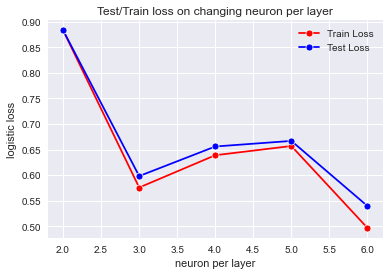

In [75]:
plt.xlabel('neuron per layer');
plt.ylabel('logistic loss');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_neuron_index, y = y_neuron_averloss_train, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = x_neuron_index, y = y_neuron_averloss_test, label = "Test Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train loss on changing neuron per layer')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

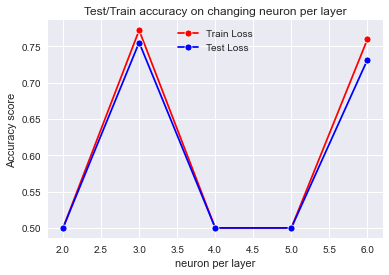

In [76]:
plt.xlabel('neuron per layer');
plt.ylabel('Accuracy score');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_neuron_index, y = y_neuron_score_train, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = x_neuron_index, y = y_neuron_score_test, label = "Test Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train accuracy on changing neuron per layer')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

## change layer  

In [77]:
x_layer_index = np.array([1,2,3,4,5])
y_layer_averloss_train = [aver_train_loss[(i-1)*50+9] for i in x_layer_index]
y_layer_averloss_test =  [aver_test_loss[(i-1)*50+9] for i in x_layer_index]

y_layer_score_train = [aver_train_score[(i-1)*50+9] for i in x_layer_index]
y_layer_score_test =  [aver_test_score[(i-1)*50+9] for i in x_layer_index]

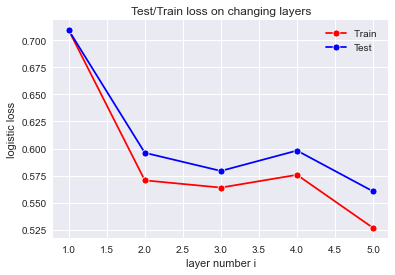

In [78]:
plt.xlabel('layer number i');
plt.ylabel('logistic loss');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_layer_index, y = y_layer_averloss_train, label = "Train ", color = "red", marker='o')
sns.lineplot(x = x_layer_index, y = y_layer_averloss_test,label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train loss on changing layers')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

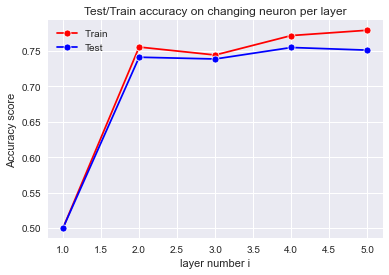

In [79]:
plt.xlabel('layer number i');
plt.ylabel('Accuracy score');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_layer_index, y = y_layer_score_train, label = "Train ", color = "red", marker='o')
sns.lineplot(x = x_layer_index, y = y_layer_score_test,label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train accuracy on changing neuron per layer')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

## max iteration

In [80]:
x_iteration_index = np.array([1,2,3,4,5,6,7,8,9,10])
starting = index_N2 - 9
y_iteration_averloss_train = [aver_train_loss[starting+i] for i in x_iteration_index]
y_iteration_averloss_test =  [aver_test_loss[starting+i] for i in x_iteration_index]


y_iteration_score_train = [aver_train_score[starting+i] for i in x_iteration_index]
y_iteration_score_test =  [aver_test_score[starting+i] for i in x_iteration_index]

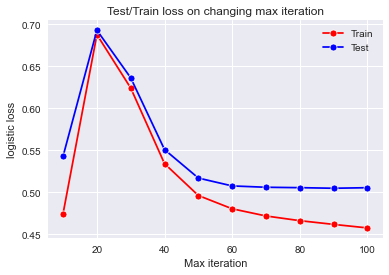

In [81]:
plt.xlabel('Max iteration');
plt.ylabel('logistic loss');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_iteration_index*10, y = y_iteration_averloss_train, label = "Train", color = "red", marker='o')
sns.lineplot(x = x_iteration_index*10, y = y_iteration_averloss_test, label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train loss on changing max iteration')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

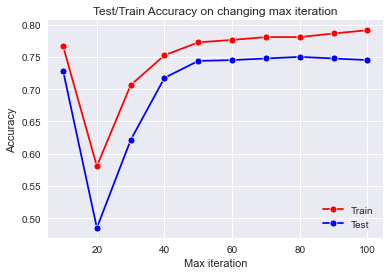

In [82]:
plt.xlabel('Max iteration');
plt.ylabel('Accuracy');
# plt.ylim([0.0, 1]);

sns.lineplot(x = x_iteration_index*10, y = y_iteration_score_train, label = "Train", color = "red", marker='o')
sns.lineplot(x = x_iteration_index*10, y = y_iteration_score_test, label = "Test", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Test/Train Accuracy on changing max iteration')
plt.show()

# print("Best C-value for LR: %.3f" % best_C) 
# print("Test set log-loss at best C-value: %.4f" % min_loss)

#### Result

In [83]:
yproba1_test = best_model.predict_proba(x_test)[:, 1] 
np.savetxt('yproba1_test.txt', yproba1_test)

In [210]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'solver':['liblinear'],'C':[0.305]}
model = sklearn.linear_model.LogisticRegression()
clf = GridSearchCV(model, parameters,cv=4)
clf.fit(X,y)
clf.cv_results_

{'mean_fit_time': array([0.01318574]),
 'std_fit_time': array([0.00112949]),
 'mean_score_time': array([0.00077999]),
 'std_score_time': array([0.00037292]),
 'param_C': masked_array(data=[0.305],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['liblinear'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.305, 'solver': 'liblinear'}],
 'split0_test_score': array([0.78333333]),
 'split1_test_score': array([0.73166667]),
 'split2_test_score': array([0.76333333]),
 'split3_test_score': array([0.75]),
 'mean_test_score': array([0.75708333]),
 'std_test_score': array([0.01886999]),
 'rank_test_score': array([1], dtype=int32)}

# Labeled data

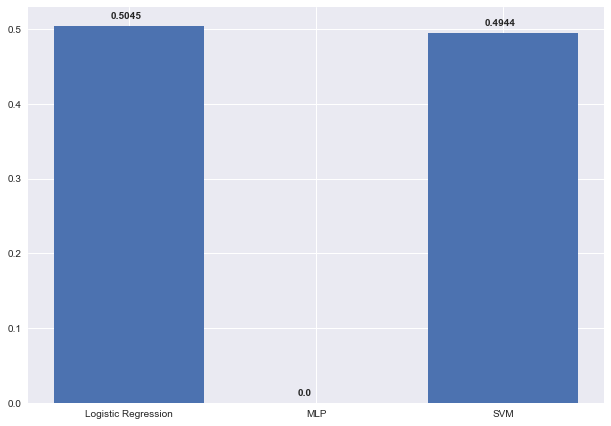

In [169]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
x = ['Logistic Regression', 'MLP', 'SVM']
students = [0.5045,0.0,0.4944]
ax.bar(x,students,label=students)

for i, v in enumerate(students):
    ax.text(i-0.1, v+0.01,str(v), fontweight='bold')
# tick_label(students)
# for index, value in enumerate(students):
#     plt.text(value, str(value))
plt.show()

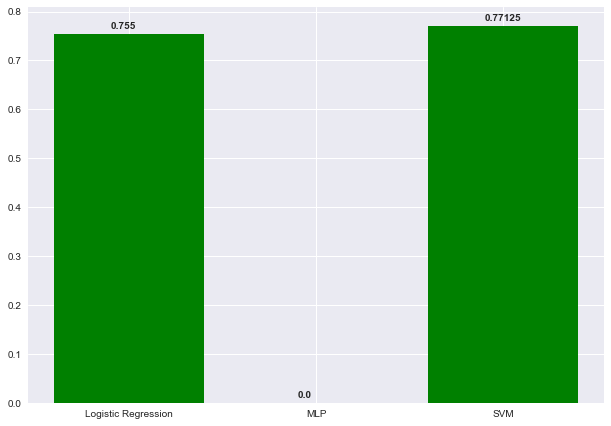

In [171]:
# ACCURACY
import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
langs = ['Logistic Regression', 'MLP', 'SVM']
students = [0.755,0.0,0.77125]
ax.bar(langs,students,color='green')

for i, v in enumerate(students):
    ax.text(i-0.1, v+0.01,str(v), fontweight='bold')
plt.show()

# Testing data

In [95]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {}
model = MLPClassifier(hidden_layer_sizes=(4,5), 
                            activation='relu',
                            solver='adam',
                            alpha=0.0001,
                            max_iter=100, tol=1e-6,
                            random_state=1)
# model = MLPClassifier(random_state:[1],hidden_layer_sizes:[4,5], activation:['relu'],solver:['adam'],alpha:[0.0001],max_iter:[100], tol:[1e-6],)
# model = MLPClassifier(random_state:[1],hidden_layer_sizes:[4,5], activation:['relu'],solver:['adam'],alpha:[0.0001],max_iter:[100], tol:[1e-6],)
# model = sklearn.linear_model.LogisticRegression()
clf = GridSearchCV(model, parameters,cv=3)
clf.fit(X,y)
clf.cv_results_

{'mean_fit_time': array([0.38784202]),
 'std_fit_time': array([0.02345143]),
 'mean_score_time': array([0.00201003]),
 'std_score_time': array([0.00211161]),
 'params': [{}],
 'split0_test_score': array([0.7325]),
 'split1_test_score': array([0.72625]),
 'split2_test_score': array([0.72875]),
 'mean_test_score': array([0.72916667]),
 'std_test_score': array([0.00256851]),
 'rank_test_score': array([1], dtype=int32)}

SyntaxError: invalid syntax (<ipython-input-92-7579f83fe13d>, line 1)

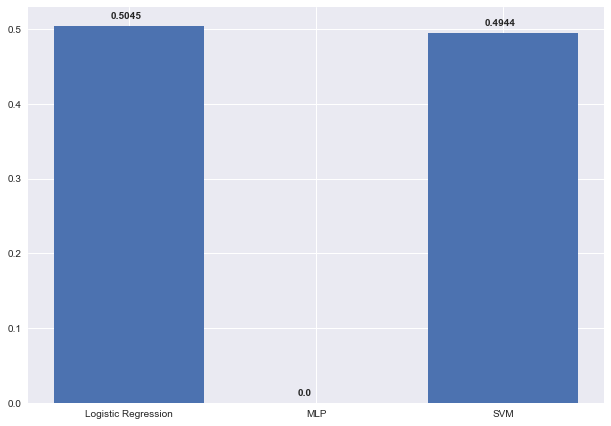

In [169]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
x = ['Logistic Regression', 'MLP', 'SVM']
students = [0.28333,0.0,0.23333]
ax.bar(x,students,label=students)

for i, v in enumerate(students):
    ax.text(i-0.1, v+0.01,str(v), fontweight='bold')
# tick_label(students)
# for index, value in enumerate(students):
#     plt.text(value, str(value))
plt.show()

In [ ]:
# ACCURACY
import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
langs = ['Logistic Regression', 'MLP', 'SVM']
students = [0.81609,0.0,0.84783]


ax.bar(langs,students,color='green')

for i, v in enumerate(students):
    ax.text(i-0.1, v+0.01,str(v), fontweight='bold')
plt.show()